#DEESHANT SHARMA
EE21MTECH14002

Project 2 for sensing and planning for autonomous vehicles


#Question
Develop an Extended Kalman Filter for the following system:
We have an object that is moving in two directions (x and y) with constant velocity (vx, vy) and
with a constant turn rate (rate is constant).
We have two sources of measurement:
1. A LIDAR sensor that measures the position of the object in (x, y) co-ordinates with some
noise
2. A RADAR that measures the position, relative velocity and heading angle (r, rdot,
heading) with some noise.

Develop an extended Kalman filter to predict the position (x, y) velocity (vx, vy), yaw and yaw
rate of the object.

Programming used: Python

In [ ]:
!pip install tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 99 kB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for tools: filename=tools-0.1.9-py3-none-any.whl size=46756 sha256=869a4db836782ec06a1ea047d145b075380b001f60fa3c6899328f27532a6c48
  Stored in directory: /root/.cache/pip/wheels/32/f1/c1/7b783d8f54066026fa6b442246d52664df9db01ed64d6eb096
  Created wheel for pytils: filename=pytils-0.4.1-py3-none-any.whl size=32525 sha256=fd95c8b4f1f7e9e24f8ef57a834370edd0b3db25338c5b54ea823f6b7f743c7d
  Stored in directory: /root/.cache/pip/wheels/19/44/3e/fed804565a6a9150b66cdf6312f1a0577c0a54c429c4911423
Successfully built tools pytils


In [1]:
#Basic libraries

import numpy as np 
from math import sin, cos, sqrt
import matplotlib.pyplot as plt
from sympy import Symbol, symbols, Matrix, sin, cos, sqrt
from sympy import init_printing

Functions for cartesian to polar and vice versa

**polar_to_cartesian(rho, phi, drho):**
 
  Converts 2D polar coordinates into cartesian coordinates

  Args:
    rho. drho : floats - radius magnitude and velocity magnitudes respectively
    phi : float - angle in radians

  Returns:
    x, y, vx, vy : floats - position and velocity components in cartesian respectively


**time_difference(t1, t2):**

  Computes the time difference in microseconds (type: float) of two epoch times values in seconds (type: int)
  
  Args:
    t1 : int - previous epoch time in seconds
    t2 : int - current epoch time in seconds

  Returns: a float - the time difference in seconds

**get_RMSE(predictions, truths):**
 
  Computes the root mean square errors (RMSE) of the attributes of two lists of DataPoint() instances

  Args:
    predictions - a list of DataPoint() instances 
    truths - a list of DataPoint() instances

  Returns:
    px, py, vx, vy - The RMSE of each respective DataPoint() attributes (type: float)

**calculate_jacobian(px, py, vx, vy, THRESH = 0.0001, ZERO_REPLACEMENT = 0.0001):**
    Calculates the Jacobian given for four state variables

    Args:
      px, py, vx, vy : floats - four state variables in the system 
      THRESH - minimum value of squared distance to return a non-zero matrix
      ZERO_REPLACEMENT - value to replace zero to avoid division by zero error

    Returns:
      H : the jacobian matrix expressed as a 4 x 4 numpy matrix with float values

  


 

In [2]:
def cartesian_to_polar(x, y, vx, vy, THRESH = 0.0001):

  rho = sqrt(x * x + y * y)
  phi = np.arctan2(y, x)
  
  
  if rho < THRESH:
    print("WARNING: in cartesian_to_polar(): d_squared < THRESH")
    rho, phi, drho = 0, 0, 0
  else:
    drho = (x * vx + y * vy) / rho
    
  return rho, phi, drho

def polar_to_cartesian(rho, phi, drho):
 
 
  x, y = rho * cos(phi), rho * sin(phi)
  vx, vy = drho * cos(phi) , drho * sin(phi)

  return x, y, vx, vy

def time_difference(t1, t2):
  
  return (t2 - t1) / 1000000.0


def get_RMSE(predictions, truths):
 
  pxs, pys, vxs, vys = [], [], [], []
  
  for p, t in zip(predictions, truths):

    ppx, ppy, pvx, pvy = p.get()
    tpx, tpy, tvx, tvy = t.get()
    
    pxs += [(ppx - tpx) * (ppx - tpx)]
    pys += [(ppy - tpy) * (ppy - tpy)]
    vxs += [(pvx - tvx) * (pvx - tvx)]
    vys += [(pvy - tvy) * (pvy - tvy)]
    
  px, py = sqrt(np.mean(pxs)), sqrt(np.mean(pys))
  vx, vy = sqrt(np.mean(vxs)), sqrt(np.mean(vys))
  
  return px, py, vx, vy  
  
def calculate_jacobian(px, py, vx, vy, THRESH = 0.0001, ZERO_REPLACEMENT = 0.0001):
 
    
  d_squared = px * px + py * py 
  d = sqrt(d_squared)
  d_cubed = d_squared * d
  
  if d_squared < THRESH:
 
    print("WARNING: in calculate_jacobian(): d_squared < THRESH")
    H = np.matrix(np.zeros([3, 4]))
 
  else:

    r11 = px / d
    r12 = py / d
    r21 = -py / d_squared
    r22 = px / d_squared
    r31 = py * (vx * py - vy * px) / d_cubed
    r32 = px * (vy * px - vx * py) / d_cubed
  
    H = np.matrix([[r11, r12, 0, 0], 
                  [r21, r22, 0, 0], 
                  [r31, r32, r11, r12]])

  return H

#Kalman filter model
1.Prediction step

2.Update/Measurement step

   A class that predicts the next state of the system given sensor measurements 
    using the Kalman Filter algorithm 

L -> LIDAR sensor datas

X position

Y position

Time

Ground truth X position

Ground truth Y position

Ground truth vx

Ground truth vy

Ground truth yaw

Ground truth yaw rate

R-> RADAR sensor datas

Distance (r)

Heading (heading)

Relative Velocity (rdot)

Time

Ground truth X position

Ground truth Y position

Ground truth vx

Ground truth vy

Ground truth yaw

Ground truth yaw rate





In [3]:
class KalmanFilter:


  def __init__(self, n):

    self.n = n
    self.I = np.matrix(np.eye(n))
    self.x = None
    self.P = None
    self.F = None
    self.Q = None
  
  def start(self, x, P, F, Q):

    self.x = x
    self.P = P
    self.F = F
    self.Q = Q
        
  def setQ(self, Q):
    self.Q = Q

  def updateF(self, dt):
    self.F[0, 2], self.F[1, 3]  = dt, dt
 
  def getx(self):
    return self.x

  def predict(self):
        
    self.x = self.F * self.x
    self.P = self.F * self.P * self.F.T + self.Q
    
  def update(self, z, H, Hx, R):

    y = z - Hx
    PHt = self.P * H.T
    S = H * PHt + R    
    K = PHt * (S.I)
    
    self.x = self.x + K * y
    self.P = (self.I - K * H) * self.P

#Extended Kalman Filter
-states are the function of time

-first order kalman filter

-used for the fusion of lidar and radar measurements


A class that gets sensor measurements from class DataPoint 
  and predicts the next state of the system using an extended Kalman filter algorithm

  The state variables we are considering in this system are the position and velocity
  in x and y cartesian coordinates, in essence there are 4 variables we are tracking.
  
  In particular, an instance of this class gets measurements from both lidar and radar sensors
  lidar sensors measure positions in cartesian coordinates (2 values)
  radar sensors measure position and velocity in polar coordinates (3 values)

  lidar sensor are linear and radar sensors are non-linear, so we use the jacobian algorithm
  to compute the state transition matrix H unlike a simple kalman filter








In [4]:

class FusionEKF:
 

  def __init__(self, d):
    self.initialized = False
    self.timestamp = 0
    self.n = d['number_of_states']
    self.P = d['initial_process_matrix']
    self.F = d['inital_state_transition_matrix']
    self.Q = d['initial_noise_matrix']
    self.radar_R = d['radar_covariance_matrix']
    self.lidar_R = d['lidar_covariance_matrix']
    self.lidar_H = d['lidar_transition_matrix']
    self.a = (d['acceleration_noise_x'], d['acceleration_noise_y'])
    self.kalmanFilter = KalmanFilter(self.n)

  def updateQ(self, dt):
    
    dt2 = dt * dt
    dt3 = dt * dt2
    dt4 = dt * dt3
    
    x, y = self.a
    
    r11 = dt4 * x / 4
    r13 = dt3 * x / 2
    r22 = dt4 * y / 4
    r24 = dt3 * y /  2
    r31 = dt3 * x / 2 
    r33 = dt2 * x
    r42 = dt3 * y / 2
    r44 = dt2 * y
    
    Q = np.matrix([[r11, 0, r13, 0],
                  [0, r22, 0, r24],
                  [r31, 0, r33, 0], 
                  [0, r42, 0, r44]])
    
    self.kalmanFilter.setQ(Q)
    
  def update(self, data):
    
    dt = time_difference(self.timestamp, data.get_timestamp())
    self.timestamp = data.get_timestamp()
        
    self.kalmanFilter.updateF(dt)
    self.updateQ(dt)
    self.kalmanFilter.predict()
    
    z = np.matrix(data.get_raw()).T
    x = self.kalmanFilter.getx()
    
    if data.get_name() == 'radar':        
      
      px, py, vx, vy = x[0, 0], x[1, 0], x[2, 0], x[3, 0]
      rho, phi, drho = cartesian_to_polar(px, py, vx, vy)
      H = calculate_jacobian(px, py, vx, vy)
      Hx = (np.matrix([[rho, phi, drho]])).T
      R = self.radar_R 
         
    elif data.get_name() == 'lidar':
    
      H = self.lidar_H
      Hx = self.lidar_H * x
      R = self.lidar_R

    self.kalmanFilter.update(z, H, Hx, R)

  def start(self, data):
    
    self.timestamp = data.get_timestamp()
    x = np.matrix([data.get()]).T
    self.kalmanFilter.start(x, self.P, self.F, self.Q)
    self.initialized = True
    
  def process(self, data):
    
    if self.initialized: 
      self.update(data)
    else:
      self.start(data)

  def get(self):
    return self.kalmanFilter.getx()

In [5]:
#Defining state
vx, vy, psis, dpsis, dts, xs, ys = symbols('vx vy \psi \dot\psi T x y')

# desired state vector
number_of_states = 6
state = Matrix([xs,ys,vx,vy,psis,dpsis])
print("state is")
state


state is


Matrix([
[       x],
[       y],
[      vx],
[      vy],
[    \psi],
[\dot\psi]])

In [6]:
# constant turn rate and constant velocity non linear plant model
gs = Matrix([[xs+((vx**2 + vy**2)**0.5)*(cos(psis))*dts],
             [ys+((vx**2 + vy**2)**0.5)*(sin(psis))*dts],
             [vx],
             [vy],
             [psis+dpsis*dts],
             [dpsis]])
gs

Matrix([
[T*(vx**2 + vy**2)**0.5*cos(\psi) + x],
[T*(vx**2 + vy**2)**0.5*sin(\psi) + y],
[                                  vx],
[                                  vy],
[                   T*\dot\psi + \psi],
[                            \dot\psi]])

In [7]:
#jacobian

gs.jacobian(state)


Matrix([
[1, 0, 1.0*T*vx*(vx**2 + vy**2)**(-0.5)*cos(\psi), 1.0*T*vy*(vx**2 + vy**2)**(-0.5)*cos(\psi), -T*(vx**2 + vy**2)**0.5*sin(\psi), 0],
[0, 1, 1.0*T*vx*(vx**2 + vy**2)**(-0.5)*sin(\psi), 1.0*T*vy*(vx**2 + vy**2)**(-0.5)*sin(\psi),  T*(vx**2 + vy**2)**0.5*cos(\psi), 0],
[0, 0,                                          1,                                          0,                                 0, 0],
[0, 0,                                          0,                                          1,                                 0, 0],
[0, 0,                                          0,                                          0,                                 1, T],
[0, 0,                                          0,                                          0,                                 0, 1]])

In [8]:
#from data analysis
#Sampling time step
dt = 1.0/10.0  # Sample Rate is 10Hz

In [9]:
# Inital Uncertainity matrix
P = np.diag([1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0])
print(P)

# Process Noise Covariance Matrix
sPos = 0.5*5*dt**2  # assume 5m/s2 as maximum acceleration, forcing the vehicle
sYaw = 0.1*dt         # assume 0.1rad/s as maximum turn rate for the vehicle
sVel = 5*dt         # assume 5m/s2 as maximum acceleration, forcing the vehicle
sYawRate = 1*dt         # assume 1.0rad/s2 as the maximum turn rate acceleration for the vehicle

Q = np.diag([sPos**2, sPos**2, sVel**2, sVel**2, sYaw**2, sYawRate**2])

# measurement covariance matrix
print("measurement covariance matrix")

R = np.matrix([[0.01, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.01, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.01, 0.0, 0.0],
               [0.0, 0.0, 0.0, 1.0e-6, 0.0],
               [0.0, 0.0, 0.0, 0.0, 0.01]])


[[1000.    0.    0.    0.    0.    0.]
 [   0. 1000.    0.    0.    0.    0.]
 [   0.    0. 1000.    0.    0.    0.]
 [   0.    0.    0. 1000.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.]
 [   0.    0.    0.    0.    0. 1000.]]
measurement covariance matrix


In [10]:
## measurement vector
hs = Matrix([[xs],
             [ys],
             [(xs**2 + ys**2)**0.5],
             [psis],
             [(xs*vx + ys*vy)/(xs**2 + ys**2)**0.5]])
hs

Matrix([
[                                  x],
[                                  y],
[                 (x**2 + y**2)**0.5],
[                               \psi],
[(x**2 + y**2)**(-0.5)*(vx*x + vy*y)]])

In [11]:


## Jacobian of hs
hs.jacobian(state)

Matrix([
[                                                                   1,                                                                    0,                       0,                       0, 0, 0],
[                                                                   0,                                                                    1,                       0,                       0, 0, 0],
[                                         1.0*x*(x**2 + y**2)**(-0.5),                                          1.0*y*(x**2 + y**2)**(-0.5),                       0,                       0, 0, 0],
[                                                                   0,                                                                    0,                       0,                       0, 1, 0],
[vx*(x**2 + y**2)**(-0.5) - 1.0*x*(x**2 + y**2)**(-1.5)*(vx*x + vy*y), vy*(x**2 + y**2)**(-0.5) - 1.0*y*(x**2 + y**2)**(-1.5)*(vx*x + vy*y), x*(x**2 + y**2)**(-0.5), y*(x**2 + y**2)**(-0.5), 0, 0]])

#Parse data
file_path 
      - path to a text file with all data. 

      - each line should have the following format:

          [SENSOR ID] [SENSOR RAW VALUES] [TIMESTAMP] [GROUND TRUTH VALUES]

          Whereas radar has three measurements (rho, phi, rhodot), lidar has two measurements (x, y).




  **State estimation **
    
  Calculates all state estimations given a FusionEKF instance() and sensor measurements


  Args:
    EKF - an instance of a FusionEKF() class 
    all_sensor_data - a list of sensor measurements as a DataPoint() instance

  Returns:
  
    all_state_estimations 
      - a list of all state estimations as predicted by the EKF instance
      - each state estimation is wrapped in  DataPoint() instance
  


In [20]:
## data parser

class DataPoint:
  """
    A set of derived information from measurements of known sensors
    NOTE: Upon instantiation of a "radar" DataPoint, state variables are computed from raw data 
  """
    
  def __init__(self, d):
    self.timestamp = d['timestamp']
    self.name = d['name']
    self.all = d
    self.raw = []
    self.data = []
    
    if self.name == 'state':
      self.data = [d['x'], d['y'], d['vx'], d['vy'], d['yaw'], d['yaw_rate']]
      self.raw = self.data.copy()
    
    elif self.name == 'lidar':
      self.data = [d['x'], d['y'], 0, 0, 0]
      self.raw = [d['x'], d['y']]
                  
    elif self.name == 'radar':
      self.data = [0, 0, d['rho'], d['phi'], d['drho']]
      self.raw = [d['rho'], d['phi'], d['drho']]
    
    self.all['processed_data'] = self.data
    self.all['raw'] = self.raw
    
  def get_dict(self):
    return self.all

  def get_raw(self):
    return self.raw

  def get(self):
    return self.data

  def get_timestamp(self):
    return self.timestamp

  def get_name(self):
    return self.name

def parse_data(file_path):

  all_sensor_data = []
  all_ground_truths = []  

  with open(file_path) as f:
      
    for line in f:
      data = line.split() 
      
      if data[0]  == 'L':
        
        sensor_data = DataPoint({ 
          'timestamp': int(data[3]),
          'name': 'lidar',
          'x': float(data[1]), 
          'y': float(data[2])
        })
        
        g = {'timestamp': int(data[3]),
             'name': 'state',
             'x': float(data[4]),
             'y': float(data[5]),
             'vx': float(data[6]),
             'vy': float(data[7]),
             'yaw' : float(data[8]),
             'yaw_rate' : float(data[9])
        }
          
        ground_truth = DataPoint(g)
                
      elif data[0] == 'R':
          
        sensor_data = DataPoint({ 
          'timestamp': int(data[4]),
          'name': 'radar',
          'rho': float(data[1]), 
          'phi': float(data[2]),
          'drho': float(data[3])
        })
       
        g = {'timestamp': int(data[4]),
             'name': 'state',
             'x': float(data[5]),
             'y': float(data[6]),
             'vx': float(data[7]),
             'vy': float(data[8]),
             'yaw' : float(data[9]),
             'yaw_rate' : float(data[10])
        }
        ground_truth = DataPoint(g)
          
      all_sensor_data.append(sensor_data)
      all_ground_truths.append(ground_truth)

  return all_sensor_data, all_ground_truths

all_sensor_data, all_ground_truths = parse_data("/content/data_ekf.txt")


In [14]:
# initial state i.e. x[0]
x = np.matrix([[1, 1, 1, 1, 1, 1]]).T
I = np.eye(number_of_states)

In [15]:
all_estimations = []

for filterstep in range(len(all_sensor_data)):

  # Prediction
  x[0] = dt * (np.sqrt(x[2] ** 2 + x[3] ** 2)) * np.cos(x[4]) + x[0] 
  x[1] = dt * (np.sqrt(x[2] ** 2 + x[3] ** 2)) * np.sin(x[4]) + x[1]
  x[2] = x[2]
  x[3] = x[3]
  x[4] = dt * x[5] + x[4] 
  x[5] = x[5]

  # Calculate the Jacobian of the Dynamic Matrix A
  a02 = float((dt * x[2] * np.cos(x[4])) / (np.sqrt(x[2] ** 2 + x[3] ** 2)))
  a03 = float((dt * x[3] * np.cos(x[4])) / (np.sqrt(x[2] ** 2 + x[3] ** 2)))
  a12 = float((dt * x[2] * np.sin(x[4])) / (np.sqrt(x[2] ** 2 + x[3] ** 2)))
  a13 = float((dt * x[3] * np.sin(x[4])) / (np.sqrt(x[2] ** 2 + x[3] ** 2)))
  a04 = float(-dt*(np.sqrt(x[2] ** 2 + x[3] ** 2)) * np.sin(x[4]))
  a14 = float(-dt*(np.sqrt(x[2] ** 2 + x[3] ** 2)) * np.cos(x[4]))

  JA = np.matrix([[1.0, 0.0, a02, a03, a04, 0.0],
                  [0.0, 1.0, a12, a13, a14, 0.0],
                  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 1.0, dt],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
  
  # Project the error covariance ahead
  P = JA*P*JA.T + Q

  # Measurement Update (Correction) & Kalman Gain
  hx = np.matrix([[float(x[0])],
                  [float(x[1])],
                  [float(np.sqrt(x[0]**2 + x[1]**2))],
                  [float(x[4])],
                  [float((x[2]*x[0] + x[3]*x[1])/(np.sqrt(x[0] ** 2 + x[1] ** 2)))]])
  
  if all_sensor_data[filterstep].get_name() == 'lidar':
    JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                   [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
  else:
    h20 = float(x[0]/(np.sqrt(x[0] ** 2 + x[1] ** 2)))
    h21 = float(x[1]/(np.sqrt(x[0] ** 2 + x[1] ** 2)))
    h40 = float((x[2] / (np.sqrt(x[0] ** 2 + x[1] ** 2))) - ((x[0] * (x[0]*[2] + x[1]*x[3])) / (np.power((x[0] ** 2 + x[1] ** 2), 1.5))))
    h41 = float((x[3] / (np.sqrt(x[0] ** 2 + x[1] ** 2))) - ((x[1] * (x[0]*[2] + x[1]*x[3])) / (np.power((x[0] ** 2 + x[1] ** 2), 1.5))))
    h42 = float(x[0]/np.sqrt(x[0] ** 2 + x[1] ** 2))
    h43 = float(x[1]/np.sqrt(x[0] ** 2 + x[1] ** 2))

    JH = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [h20, h21, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                    [h40, h41, h42, h43, 0.0, 0.0]])
    
  S = JH*P*JH.T + R
  K = (P*JH.T) * np.linalg.inv(S)

  # Update the estimate via
  Z = np.array(all_sensor_data[filterstep].get_dict()['processed_data']).reshape(JH.shape[0],1)
  y = Z - (hx)                         
  x = x + (K*y)

  # Update the error covariance
  P = (I - (K*JH))*P

  # save states for analysis
  all_estimations.append(x.reshape(-1).tolist())

In [16]:
def print_EKF_data(all_sensor_data, all_ground_truths, all_state_estimations):

  pred_x=[]
  pred_y=[]
  truth_x=[]
  truth_y=[]
  
  print("-----------------------------------------------------------")
  print("NUMBER OF DATA POINTS:", len(all_sensor_data))
  print("-----------------------------------------------------------")  

  i = 1
  for s, p, t in zip(all_sensor_data, all_state_estimations, all_ground_truths):
      
    print("-----------------------------------------------------------")
    print("#", i, ":", s.get_timestamp())
    print("-----------------------------------------------------------")  

    if s.get_name() == 'lidar':
      x, y = s.get_raw()
      print('{:15s} | {:8.3f} | {:8.3f} |'.format("LIDAR:", x, y))
    else:
      rho, phi, drho = s.get_raw()
      print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("RADAR:", rho, phi, drho))  

    x = all_state_estimations[i-1][0][0]
    y = all_state_estimations[i-1][0][1]
    vx = all_state_estimations[i-1][0][2]
    vy = all_state_estimations[i-1][0][3]
    psi = all_state_estimations[i-1][0][4]
    dpsi = all_state_estimations[i-1][0][5]
    print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("PREDICTION:", x, y, vx, vy, psi, dpsi))  
    pred_x = np.append(pred_x,x)
    pred_y = np.append(pred_y,y)
    x, y, vx, vy, psi, dpsi = t.get()
    print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("TRUTH:", x, y, vx, vy, psi, dpsi))  
    truth_x = np.append(truth_x,x)
    truth_y = np.append(truth_y,y)
    i += 1
  return pred_x,pred_y,truth_x,truth_y

#Output with state estimations

In [17]:
#Printing all results
print_EKF_data(all_sensor_data, all_ground_truths, all_estimations)

-----------------------------------------------------------
NUMBER OF DATA POINTS: 500
-----------------------------------------------------------
-----------------------------------------------------------
# 1 : 1477010443000000
-----------------------------------------------------------
LIDAR:          |    0.312 |    0.580 |
PREDICTION:     |    0.312 |    0.580 |    0.950 |    0.950 |    1.111 |    1.000 |
TRUTH:          |    0.600 |    0.600 |    5.200 |    0.000 |    0.000 |    0.007 |
-----------------------------------------------------------
# 2 : 1477010443050000
-----------------------------------------------------------
RADAR:          |    1.015 |    0.554 |    4.893 |
PREDICTION:     |    0.492 |    0.890 |   -2.588 |    7.060 |    0.554 |   -1.013 |
TRUTH:          |    0.860 |    0.600 |    5.200 |    0.002 |    0.000 |    0.014 |
-----------------------------------------------------------
# 3 : 1477010443100000
---------------------------------------------------------

(array([ 3.12249408e-01,  4.92097522e-01,  1.09926565e+00,  1.31644974e+00,
         1.77091416e+00,  1.98128022e+00,  2.43746999e+00,  2.60195451e+00,
         3.01155913e+00,  3.29981528e+00,  3.61754093e+00,  3.94245916e+00,
         4.33625924e+00,  4.66493840e+00,  4.98821399e+00,  5.23867482e+00,
         5.36591611e+00,  5.55027683e+00,  5.93753831e+00,  5.99543796e+00,
         6.36498001e+00,  6.48373482e+00,  6.77449234e+00,  7.03242260e+00,
         7.31659197e+00,  7.63232999e+00,  7.81336617e+00,  8.24624192e+00,
         8.43978214e+00,  8.77356183e+00,  8.90342518e+00,  9.08608751e+00,
         9.41806472e+00,  9.94055215e+00,  9.99048484e+00,  1.04560828e+01,
         1.05248606e+01,  1.09518565e+01,  1.09288973e+01,  1.13070445e+01,
         1.13050654e+01,  1.17381863e+01,  1.19695318e+01,  1.21411228e+01,
         1.23432645e+01,  1.26496493e+01,  1.29095301e+01,  1.31517404e+01,
         1.33805899e+01,  1.37261681e+01,  1.39372031e+01,  1.39333164e+01,
         1.4

-----------------------------------------------------------
NUMBER OF DATA POINTS: 500
-----------------------------------------------------------
-----------------------------------------------------------
# 1 : 1477010443000000
-----------------------------------------------------------
LIDAR:          |    0.312 |    0.580 |
PREDICTION:     |    0.312 |    0.580 |    0.950 |    0.950 |    1.111 |    1.000 |
TRUTH:          |    0.600 |    0.600 |    5.200 |    0.000 |    0.000 |    0.007 |
-----------------------------------------------------------
# 2 : 1477010443050000
-----------------------------------------------------------
RADAR:          |    1.015 |    0.554 |    4.893 |
PREDICTION:     |    0.492 |    0.890 |   -2.588 |    7.060 |    0.554 |   -1.013 |
TRUTH:          |    0.860 |    0.600 |    5.200 |    0.002 |    0.000 |    0.014 |
-----------------------------------------------------------
# 3 : 1477010443100000
---------------------------------------------------------

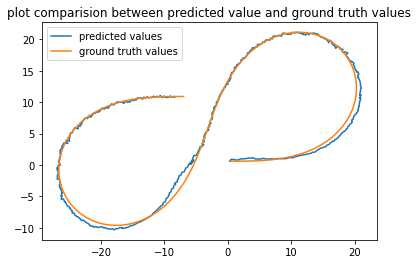

In [18]:
#printing all results with graph
[pred_x,pred_y,truth_x,truth_y] = print_EKF_data(all_sensor_data, all_ground_truths, all_estimations)
plt.figure()
plt.plot(pred_x,pred_y,label="predicted values")
plt.plot(truth_x,truth_y,label="ground truth values")
plt.title("plot comparision between predicted value and ground truth values")
plt.legend()
plt.show()